## <font color=orange>Subduction Zone Kinematics: calculating area and volume flux</font>
#### <font color=blue>Notebook 2</font>

This notebook illustrates how the subduction zone kinematics genereated in the first notebook ('Make-Subduction-Stats-Table-notebook1.ipynb') can be used to calculate subducting plate area and slab flux. It also illustrates how this data can be visualised and plotted.

This notebook therefore uses data precomputed and stored in a csv file, and loaded into a pandas data table for manipulation.


This was the second in a series of notebooks used to generate the data presened in the following manuscript:

*'Subduction history reveals Cretaceous slab superflux as a possible cause for the mid-Cretaceous plume pulse and superswell events'* by Madison East, R Dietmar Müller, Simon Williams, Sabin Zahirovic and Christian Heine


(Notebook written by Simon Williams and modified made by Madison East)



In [1]:
# This cell loads in the required files for the chosen plate model, as well as the precomputed data #
#####################################################################################################

import pygplates
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.basemap import Basemap
from topology_plotting import *
from matplotlib.patches import Polygon
from scipy.special import erfinv
import pandas as pd
import math
import statistics
from lithosphere_thickness_plate_model import * # this loads in the coded which is used later to convert seafloor age to lithospheric thickness

%matplotlib inline

#######################################################
# Define Input files for Muller 2016 AREPS model
#######################################################
# Specify the name of the GPlates rotation file
rotation_filename = '../Data_AREPS_clean/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

# input topologies to be used with the subduction_convergence script
input_topology_filename = ['../Data_AREPS_clean/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',\
             '../Data_AREPS_clean/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

# Static polygons to determine whether subduction segment is adjacent to continent or not
static_polygon_filename = '../Data_AREPS_clean/Shapefiles/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2015_v1.shp'
static_polygon_features = pygplates.FeatureCollection(static_polygon_filename)
continental_polygon_features = []
for feature in static_polygon_features:
    if feature.get_feature_type() == pygplates.FeatureType.gpml_closed_continental_boundary:
        continental_polygon_features.append(feature)


######################################################
rotation_model = pygplates.RotationModel(rotation_filename)

# specify time range and resolution for plots
threshold_sampling_distance_radians = np.radians(0.5)

# Define the time snapshots at which to get the subduction zone properties
min_time = 0.
max_time = 230.
time_step = 1.

# Set the delta time for velocity calculations
velocity_delta_time = 1.

# Typically the achor plate id should be 0
anchor_plate_id = 0

############################################################################################################
# Previously calculated results are loaded here from a .csv file, and stored in a pandas data table.
# This is the data that was generated in the first notebook ('Make-Subduction-Stats-Table-notebook1.ipynb')
df = pd.read_csv('SubductionTable_clean_0_230Ma.csv')

# This takes care of any minor construction errors in the plate model where small sections of convergence zones may momentarily become divergent
# this converts any negative convergence rate to zero (these were very minor occurances in the AREPS model, but if using a new model, check these instances first)
df.ix[df.conv_rate<0,'conv_rate'] = 0

############################################################################################################
# Below we calculate the orthogonal migration and convergence rates, which are important to get true estimates of area and volume flux

mr = np.asarray(df['migr_rate'])
mo = np.asarray(df['migr_obliq'])
df['ortho_migr_rate'] = pd.Series(mr*np.sin(np.radians(np.abs(mo))), index=df.index)

cr = np.asarray(df['conv_rate'])
co = np.asarray(df['conv_obliq'])
df['ortho_conv_rate'] = pd.Series(cr*np.abs(np.cos(np.radians(co))), index=df.index)


### Time for the calculations...

In [2]:
########### Lithospheric Thickness and Subduction Volume Calculations  ###############

## Thickness (in metres): Equation and constants from 'The Solid Earth' (2005), Sandwell (2001) and Grose et al. (2012) 
## T-values in degrees celcius, thermal diffusivity (k) in m^2/sec
T1 = 1150.
To = 0.
Tm = 1350.
kappa = 0.804e-6
Myr2sec=1e6*365*24*60*60
lithosphere_thickness_boundarylayer = erfinv((T1-To)/(Tm-To))*2*np.sqrt(kappa)*np.sqrt(Myr2sec*np.asarray(df['SeafloorAge']))

for i in range(0, len(lithosphere_thickness_boundarylayer)):
    if (lithosphere_thickness_boundarylayer[i] > 125000) :
        lithosphere_thickness_boundarylayer[i] = 125000
        
## Thickness using translated MATLAB script
lithosphere_thickness_plate_model = list(lithosphere_thickness_boundarylayer)
for i in range(0, len(lithosphere_thickness_boundarylayer)) :
#for i in range(0, 100) :
    lithosphere_thickness_plate_model[i] = plate_isotherm_depth(np.asarray(df['SeafloorAge'])[i], T1)

## To convert arc_length from degrees on a sphere to m (using earth's radius = 6371000 m)
arc_length_m = 2*math.pi*6371000*((np.asarray(df['arc_length']))/360)

## Calculate Subduction Volume (in m^3 per year)
subduction_volume_m3y = (np.asarray(df['ortho_conv_rate'])/100) * lithosphere_thickness_plate_model * arc_length_m

## Calculate Subduction Volume (in m^3 per Ma)
subduction_volume_m3Ma = (np.asarray(df['ortho_conv_rate'])/100) * lithosphere_thickness_plate_model * arc_length_m * 1e6

## Calculate Subduciton Volume (slab flux) (in km^3 per year)
subduction_volume_km3y = subduction_volume_m3y/1e9 

print len(df)
print np.asarray(df['SeafloorAge'])
print lithosphere_thickness_boundarylayer
print arc_length_m
print subduction_volume_m3y
#print lithosphere_thickness_plate_model
#print pd.Series(lithosphere_thickness)

# Add the parameters calculated above to our data table
df['arc_length_m'] = pd.Series(arc_length_m, index=df.index)
df['lithosphere_thickness_boundarylayer'] = pd.Series(lithosphere_thickness_boundarylayer, index=df.index)
df['lithosphere_thickness_plate_model'] = pd.Series(lithosphere_thickness_plate_model, index=df.index)
df['subduction_volume_m3y'] = pd.Series(subduction_volume_m3y, index=df.index)
df['subduction_volume_m3Ma'] = pd.Series(subduction_volume_m3Ma, index=df.index)
df['subduction_volume_km3y'] = pd.Series(subduction_volume_km3y, index=df.index)


########## Area calculations ##############

#To calculate subducting plate area (in m^2/year)
subduction_area_m2y = (np.asarray(df['ortho_conv_rate'])/100) * arc_length_m 

# To calculate subducitng plate area (in km^2/year)
subduction_area_km2y = subduction_area_m2y/1e6

df['subduction_area_m2y'] = pd.Series(subduction_area_m2y, index=df.index)
df['subduction_area_km2y'] = pd.Series(subduction_area_km2y, index=df.index)


df_AllTimes = df

# Display the contents of the table containing all subduction
df

321717
[ 94.24191127  72.35111854  77.42189568 ...,  67.6050886   44.97306238
  64.05952335]
[ 99969.55834454  87592.78918647  90610.31313009 ...,  84671.1432922
  69059.26653362  82420.94359995]
[ 45331.3158483   52041.2736646   37683.65670452 ...,  55477.71898856
  54628.21713064  54628.2171303 ]
[  1.65814513e+08   1.68750456e+08   1.25768497e+08 ...,   4.79583731e+08
   3.64765196e+08   4.24554307e+08]


,Unnamed: 0,DistanceToContinent,NearestContinentPID,SeafloorAge,arc_azimuth,arc_length,conv_obliq,conv_rate,lat,lon,...,ortho_migr_rate,ortho_conv_rate,arc_length_m,lithosphere_thickness_boundarylayer,lithosphere_thickness_plate_model,subduction_volume_m3y,subduction_volume_m3Ma,subduction_volume_km3y,subduction_area_m2y,subduction_area_km2y
0,0,0.000000,16130.0,94.241911,7.048196,0.407674,-55.309337,6.812935,50.444919,-179.937442,...,0.323847,3.877552,45331.315848,99969.558345,94333.648682,1.658145e+08,1.658145e+14,0.165815,1757.745150,0.001758
1,1,104.296523,806.0,72.351119,293.688940,0.468018,-39.017566,4.843504,-37.283931,-179.904160,...,-3.481392,3.763175,52041.273665,87592.789186,86167.335510,1.687505e+08,1.687505e+14,0.168750,1958.404018,0.001958
2,2,1675.109671,844.0,77.421896,196.384032,0.338897,65.727968,9.177222,-11.225768,-179.705383,...,7.377545,3.772475,37683.656705,90610.313130,88469.266891,1.257685e+08,1.257685e+14,0.125768,1421.606633,0.001422
3,3,147.636960,806.0,72.765439,293.547286,0.468018,-38.350411,4.914457,-36.855115,-179.669162,...,-3.481392,3.854068,52041.273664,87843.232367,86365.699768,1.732242e+08,1.732242e+14,0.173224,2005.706237,0.002006
4,4,170.352834,823.0,73.459981,293.408606,0.468018,-37.704138,4.985854,-36.425842,-179.436788,...,-3.481392,3.944705,52041.273664,88261.465907,86694.002151,1.779719e+08,1.779719e+14,0.177972,2052.874628,0.002053
5,5,1694.367534,844.0,77.323223,196.319209,0.338897,65.996958,9.157936,-11.321178,-179.373795,...,7.377545,3.725312,37683.656704,90552.554066,88427.066803,1.241369e+08,1.241369e+14,0.124137,1403.833852,0.001404
6,6,0.000000,16130.0,94.366152,7.537337,0.407674,-55.516762,6.795949,50.393168,-179.302793,...,0.323847,3.847629,45331.315848,100035.432454,94368.219376,1.645953e+08,1.645953e+14,0.164595,1744.181052,0.001744
7,7,147.946897,823.0,74.696435,293.272837,0.468018,-37.077989,5.057658,-35.996123,-179.206970,...,-3.481392,4.035078,52041.273665,89001.159971,87265.729904,1.832498e+08,1.832498e+14,0.183250,2099.906044,0.002100
8,8,1714.223219,844.0,76.903078,196.253802,0.338897,66.267825,9.138799,-11.416219,-179.041987,...,7.377545,3.678019,37683.656704,90306.205114,88246.107101,1.223102e+08,1.223102e+14,0.122310,1386.011957,0.001386
9,9,127.142407,823.0,75.319742,286.827791,0.490832,-30.178118,5.134455,-35.546225,-179.005424,...,-3.836825,4.438566,54578.024755,89371.725706,87547.779083,2.120829e+08,2.120829e+14,0.212083,2422.481585,0.002422


In [3]:
# Save data to csv file!!
df_AllTimes.to_csv('SubductionVolumesAreaTable_clean_%0.0f_%0.0fMa.csv' % (min_time,max_time))

### Visualisation...

The plot below shows time snapshots of the model plate boundaries and allows you to visualise your calcualted data
- each subduction zone segment is represented by a coloured dot, and according to the colour map, depicting what you have chosen to plot (e.g. slab flux or subducting plate area)
- bright blue lines show mid-ocean ridges
- orange lines show 'other' plate boundaries

You can choose what range of time steps you want to plot and what calculation to show. Plot features can be altered and the maps can be exported. By exporting all time steps, you have the potential to generate an animation.


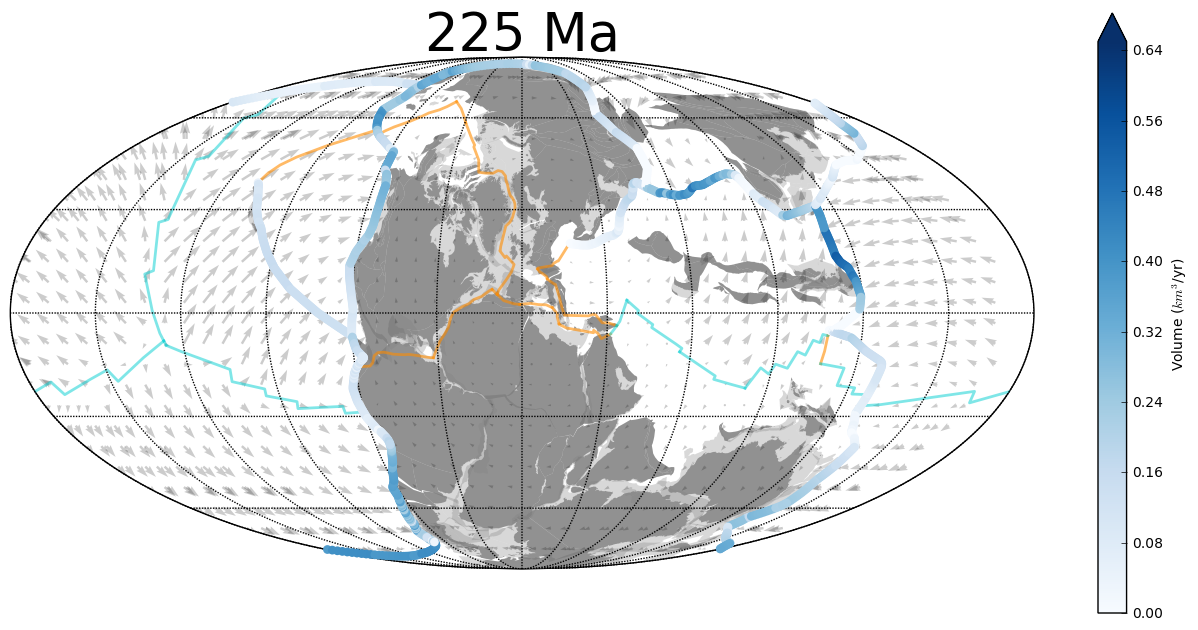

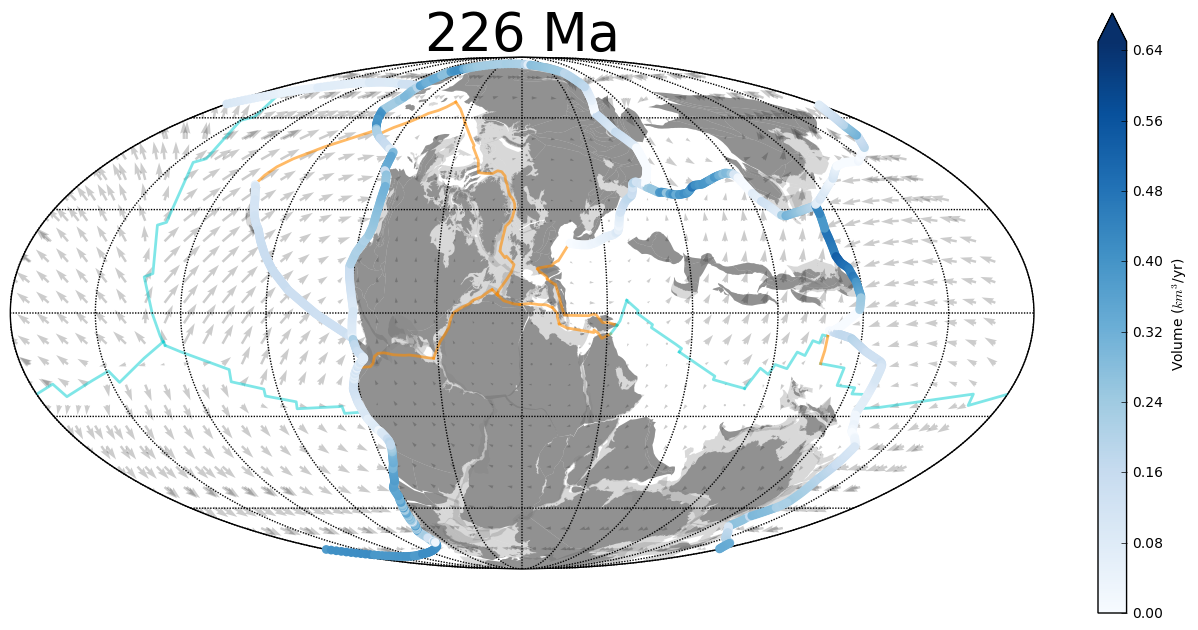

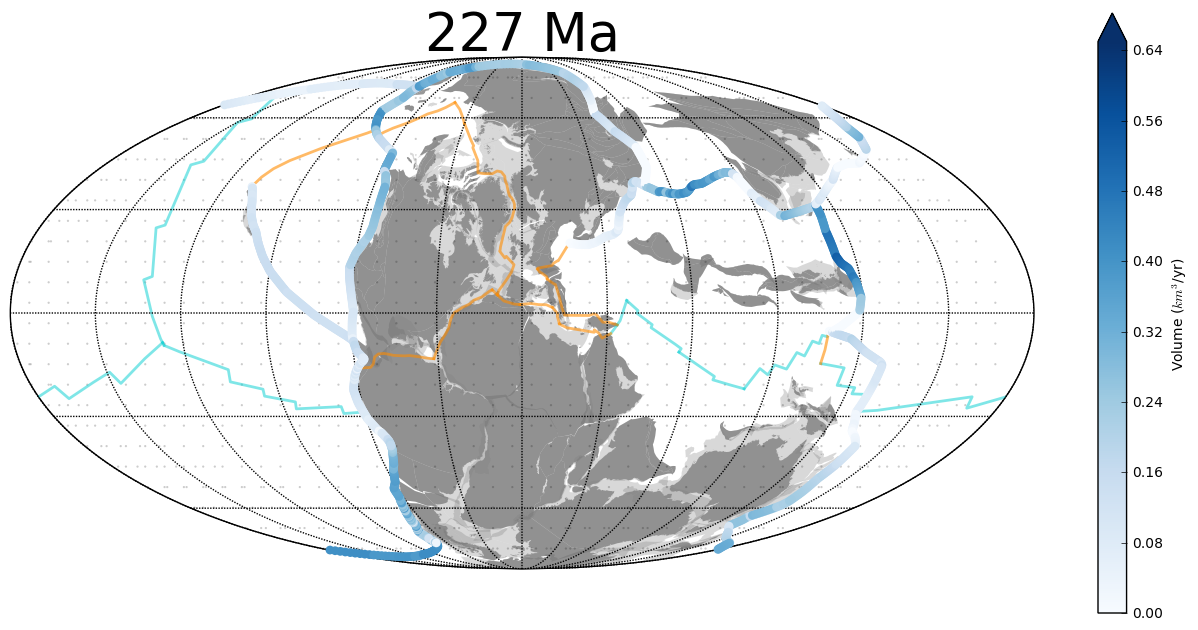

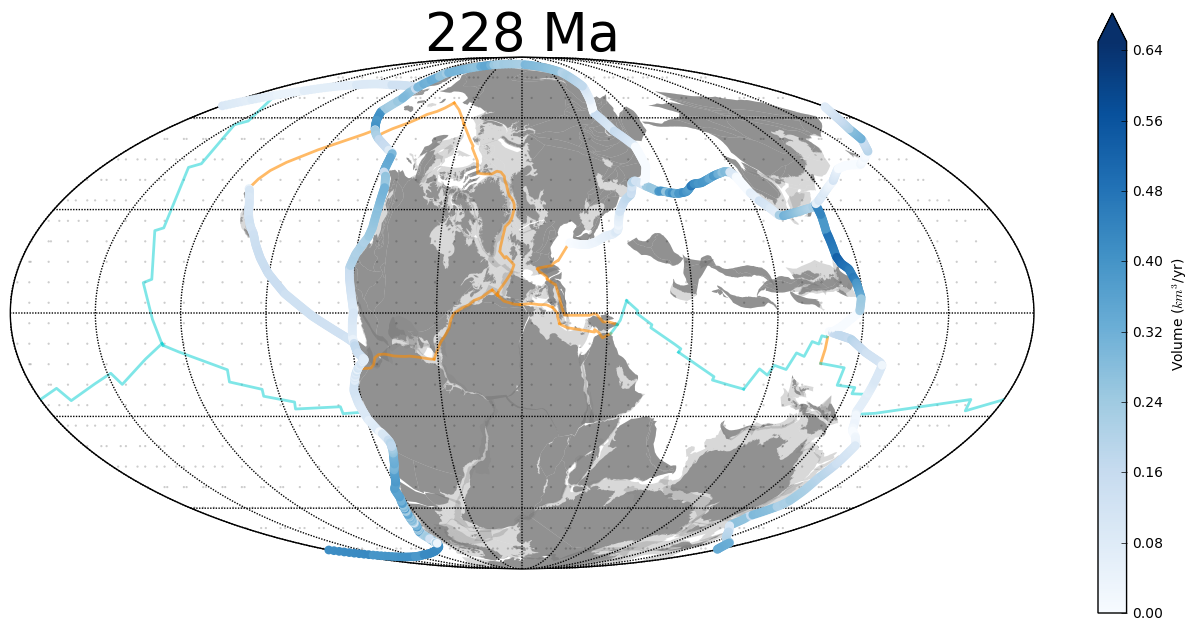

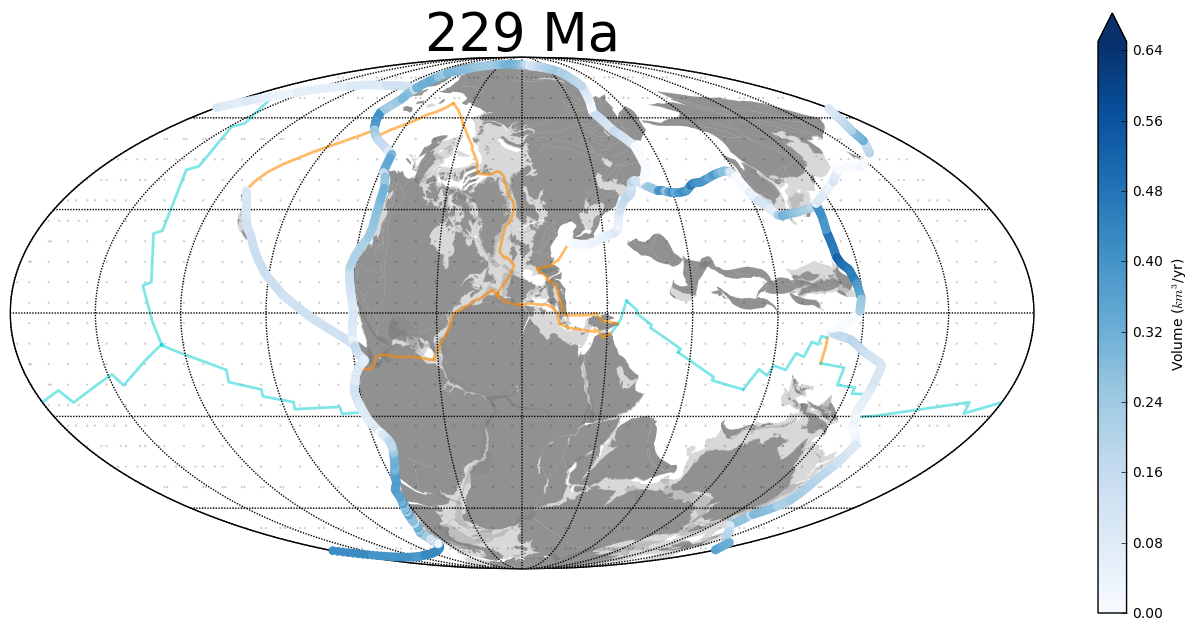

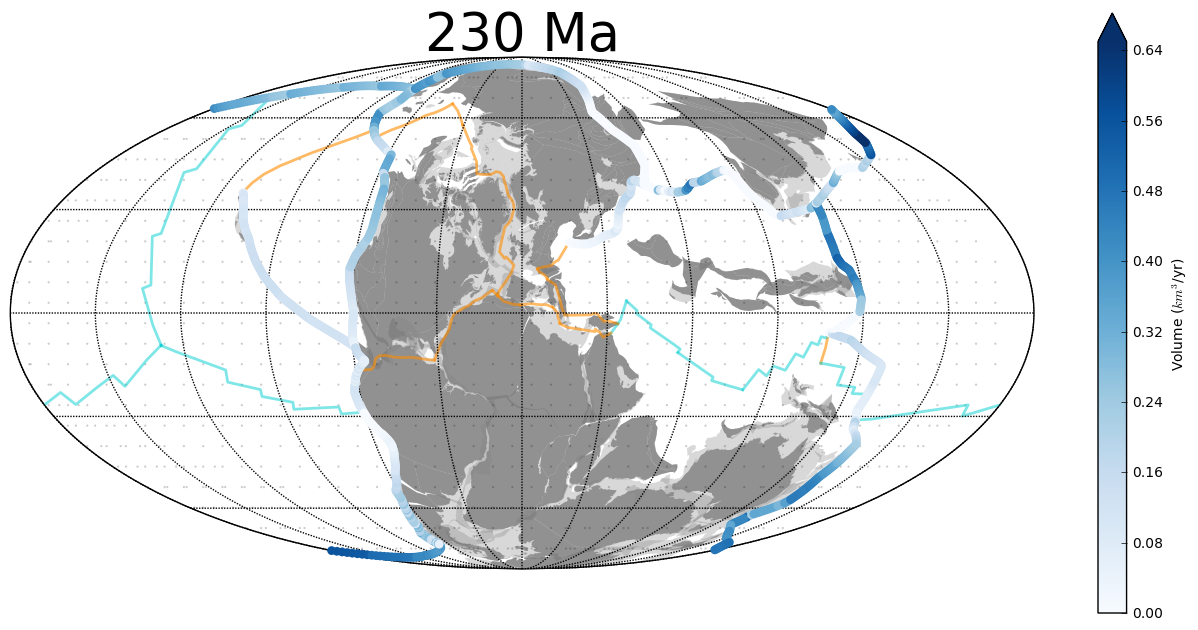

In [10]:
import matplotlib.patches as mpatches
from topology_plotting import *

#Define which timesteps you want to plot
times = np.arange(225,231,1)
for time in times:
    subset = df_AllTimes[(df_AllTimes['time']==time)]

    coastlines_file = '../Data_most_recent/Global_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpmlz'
    pygplates.reconstruct(coastlines_file, rotation_model, 'tmp.shp', time)

    pygplates.reconstruct(continental_polygon_features, rotation_model, 'tmp2.shp', time)

    fig = plt.figure(figsize=(16,6),dpi=150)
    ax_map = fig.add_axes([0,0,0.8,1.0])
    lon0=0
    m = Basemap(projection='moll', lon_0=lon0, resolution='c', ax=ax_map)
    #m = Basemap(resolution='c',projection='ortho',lat_0=30.,lon_0=lon0)
    cp = m.drawmapboundary()
    m.drawparallels(np.arange(-90,90,30))
    m.drawmeridians(np.arange(-180,180,30))

    # Plot reconstructed coastlines
    shp_info = m.readshapefile('tmp','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.8,zorder=0.5)
        plt.gca().add_patch(poly)

    # Plot reconstructed continental shelf
    shp_info = m.readshapefile('tmp2','shp',drawbounds=True,color='none')
    for nshape,seg in enumerate(m.shp):
        poly = Polygon(seg,facecolor='grey',edgecolor='none',alpha=0.3,zorder=0.25)
        plt.gca().add_patch(poly)

    plot_velocities_and_topologies(m,input_topology_filename,rotation_model,time,
                                   delta_time=5,res=10,scale=4000,lon0=lon0,clip_path=cp)

    # in the below lines you define which of your calculations you want to plot e.g. subduction_volume_km3y
    x, y = m(np.asarray(subset.lon), np.asarray(subset.lat))
    l1 = m.scatter(x,y,c=subset['subduction_volume_km3y'],s=40,edgecolor='',zorder=5,
                   cmap=plt.cm.Blues,vmin=0,vmax=6.5e-1)

    #plt.title('Subduction Volume Flux (%s Ma)' % time, size=18)
    plt.title('%s Ma' % time, size=38)

    plt.colorbar(l1,extend='max',label='Volume ($km^3$/yr)')
    
    #velocity = mpatches.Patch(color='w', label='Velocity Vectors',alpha=0.4)
    #MOR = mpatches.Patch(color='darkturquoise', label='Mid Ocean Ridge',alpha=0.5)
    #transform = mpatches.Patch(color='darkorange', label='Fracture Zones',alpha=0.6)
    #continents = mpatches.Patch(color='grey', label='Continental Shelf',alpha=0.3)
    #coastlines = mpatches.Patch(color='grey', label='Continents',alpha=0.7)
    
    #plt.legend(handles=[velocity, MOR, transform, continents, coastlines], loc=1)
    

    #plt.savefig('Volume_flux_animation/figures_vol/Subduction_Volume_Flux_%s Ma.jpeg' % time ,bbox_inches='tight', dpi=300)

### Total Volume (slab flux)
To understand temporal changes, rather than spatial variation at a single time step, we will need to combine the data from our numerous subduction segments at each time step. The below cell sums the total subduction volume for each 1 Ma timestep and saves it as a csv file. A separate file is made for volume per year and per Ma.

In [7]:
#Saving Summed Values for 'm^3 per year'

times = np.arange(0,231,1)
total_sub_volume_m3y = []
for time in times:
    subset1 = df_AllTimes[(df_AllTimes['time']==time)]
    total_sub_volume_m3y.append(math.fsum(subset1.subduction_volume_m3y))    
#print total_sub_volume_m3y

data = pd.DataFrame()
data['Time_(Ma)'] = pd.Series(times)
data['Subduction_Volume_Flux_(m^3/year)'] = pd.Series(total_sub_volume_m3y)
data
data.to_csv('Summed_data_plus_stats/Subduction_Volume_Flux_Summed_Data_clean_m3y_%0.0f_%0.0fMa.csv' % (min_time,max_time))

In [8]:
#Saving Summed Values for 'm^3 per Ma'

times = np.arange(0,231,1)
total_sub_volume_m3Ma = []
for time in times:
    subset1 = df_AllTimes[(df_AllTimes['time']==time)]
    total_sub_volume_m3Ma.append(math.fsum(subset1.subduction_volume_m3Ma))    
#print total_sub_volume_m3Ma

data = pd.DataFrame()
data['Time_(Ma)'] = pd.Series(times)
data['Subduction_Volume_Flux_(m^3/Ma)'] = pd.Series(total_sub_volume_m3Ma)
data
data.to_csv('Summed_data_plus_stats/Subduction_Volume_Flux_Summed_Data_clean_m3Ma_%0.0f_%0.0fMa.csv' % (min_time,max_time))

In [9]:
#Saving Summed Values for 'km^3 per yr'

times = np.arange(0,231,1)
total_sub_volume_km3y = []
for time in times:
    subset1 = df_AllTimes[(df_AllTimes['time']==time)]
    total_sub_volume_km3y.append(math.fsum(subset1.subduction_volume_km3y))    
#print total_sub_volume_km3y

data = pd.DataFrame()
data['Time_(Ma)'] = pd.Series(times)
data['Subduction_Volume_Flux_(km^3/year)'] = pd.Series(total_sub_volume_km3y)
data
data.to_csv('Summed_data_plus_stats/Subduction_Volume_Flux_Summed_Data_clean_km3y_%0.0f_%0.0fMa.csv' % (min_time,max_time))

### Total Area (subducting plate area)
Here we do the same thing that was done for volume, but for area values instead.

In [11]:
#Summing area values for subducting plate area (in m^2/yr)

times = np.arange(0,231,1)
total_sub_area_m2y = []
for time in times:
    subset1 = df_AllTimes[(df_AllTimes['time']==time)]
    total_sub_area_m2y.append(math.fsum(subset1.subduction_area_m2y))
#print total_sub_area_m2y 

data = pd.DataFrame()
data['Time_(Ma)'] = pd.Series(times)
data['Subduction_Area_Flux_(m^2/year)'] = pd.Series(total_sub_area_m2y)
data
data.to_csv('Summed_data_plus_stats/Subduction_Area_Flux_Summed_Data_clean_m2y_%0.0f_%0.0fMa.csv' % (min_time,max_time))

In [12]:
#Summing area values for subducting plate area (in km^2/yr)

times = np.arange(0,231,1)
total_sub_area_km2y = []
for time in times:
    subset1 = df_AllTimes[(df_AllTimes['time']==time)]
    total_sub_area_km2y.append(math.fsum(subset1.subduction_area_km2y))
#print total_sub_area_km2y 

data = pd.DataFrame()
data['Time_(Ma)'] = pd.Series(times)
data['Subduction_Area_Flux_(km^2/year)'] = pd.Series(total_sub_area_km2y)
data
data.to_csv('Summed_data_plus_stats/Subduction_Area_Flux_Summed_Data_clean_km2y_%0.0f_%0.0fMa.csv' % (min_time,max_time))